In [7]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# SPDX-License-Identifier: CC-BY-4.0
#
# Code for "Bayesian continual learning and forgetting in neural networks"
# Djohan Bonnet, Kellian Cottart, Tifenn Hirtzlin, Tarcisius Januel, Thomas Dalgaty, Elisa Vianello, Damien Querlioz
# arXiv: 2504.13569
# Portions of the code are adapted from the Pytorch project (BSD-3-Clause)
#
# Author: Kellian Cottart <kellian.cottart@gmail.com>
# Date: 2025-07-03

In [8]:

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import os
import seaborn as sns
import re
import json
import pandas as pd
AXESSIZE = 28
FONTSIZE = 26
TICKSIZE = 24   
LEGENDSIZE = 26
plt.rcParams['svg.fonttype'] = 'none'
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.8"
FOLDER = "output-figures"
os.makedirs(FOLDER, exist_ok=True)
results_folder = "RESULTS-UCB"
df = pd.DataFrame()
# iterate through all root folders in the results folder
for folder in os.listdir(results_folder):
    current_path = os.path.join(results_folder, folder)
    # extract the name from the first config
    config_path = os.path.join(current_path, "config0/config.json")
    with open(config_path, "r") as f:
        config = json.load(f)
    # n_iterations is the number of config folders
    n_iterations = len([f for f in os.listdir(current_path) if f.startswith("config") and os.path.isdir(os.path.join(current_path, f))])
    
    # Add the row of parameters to the dataframe   
    row = {
        "path": current_path,
        "opt": config["optimizer"],
        "layers": int(config["network_params"]["layers"][:-1][1:][0]),
        "n_tasks": config["n_tasks"],
        "n_epochs": config["epochs"],
        "n_train_samples": config["n_train_samples"],
        "n_test_samples": config["n_test_samples"],
        "N": int(config["optimizer_params"]["N"]),
        "n_iterations": n_iterations,
    }
    df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
# One color for each path
colors = sns.color_palette("viridis", len(df["path"].unique()))
markers = ["D", "o", "s", "h", "^", "x", "v", "p", "*", "X", "D", "o", "s", "h", "^", "x", "v", "p", "*", "X"]

In [9]:
df

,path,opt,layers,n_tasks,n_epochs,n_train_samples,n_test_samples,N,n_iterations
0,RESULTS-UCB/20250704-144810-permutedmnist-t=10...,mesu,128,10,200,10,10,2800000,5
1,RESULTS-UCB/20250711-173638-permutedmnist-t=10...,mesu,1200,10,200,10,10,9300000,5


In [10]:
data = []
for idx, row in df.iterrows():
    path = row["path"]
    n_tasks = row["n_tasks"]
    n_epochs = row["n_epochs"]
    n_iterations = row["n_iterations"]
    full_accuracies = []
    full_epistemic_auc = []
    full_aleatoric_auc = []
    for it in range(n_iterations):
        current_it_path = os.path.join(path, f"config{it}")
        accuracy_path = os.path.join(current_it_path, "accuracy")
        uncertainty_path = os.path.join(current_it_path, "uncertainty")
        accuracies = []
        epistemic_auc = []
        aleatoric_auc = []
        for task in range(n_tasks):
            for epoch in range(n_epochs):
                suffix = f"task={task}-epoch={epoch}.npy"
                accuracies.append(jnp.load(os.path.join(accuracy_path, suffix)))
        full_accuracies.append(jnp.array(accuracies)) 
        full_epistemic_auc.append(jnp.array(epistemic_auc))
        full_aleatoric_auc.append(jnp.array(aleatoric_auc))
    full_accuracies = jnp.array(full_accuracies)
    accuracy_array = jnp.mean(full_accuracies, 0)[-1].mean()
    accuracy_std = jnp.std(full_accuracies, 0)[-1].mean()
    data.append((accuracy_array, accuracy_std))
# Add new columns to df
df["last_accuracies"] = [d[0] for d in data]
df["last_accuracies_std"] = [d[1] for d in data]

In [11]:
df

,path,opt,layers,n_tasks,n_epochs,n_train_samples,n_test_samples,N,n_iterations,last_accuracies,last_accuracies_std
0,RESULTS-UCB/20250704-144810-permutedmnist-t=10...,mesu,128,10,200,10,10,2800000,5,0.920492,0.010886136
1,RESULTS-UCB/20250711-173638-permutedmnist-t=10...,mesu,1200,10,200,10,10,9300000,5,0.945296,0.009284424


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


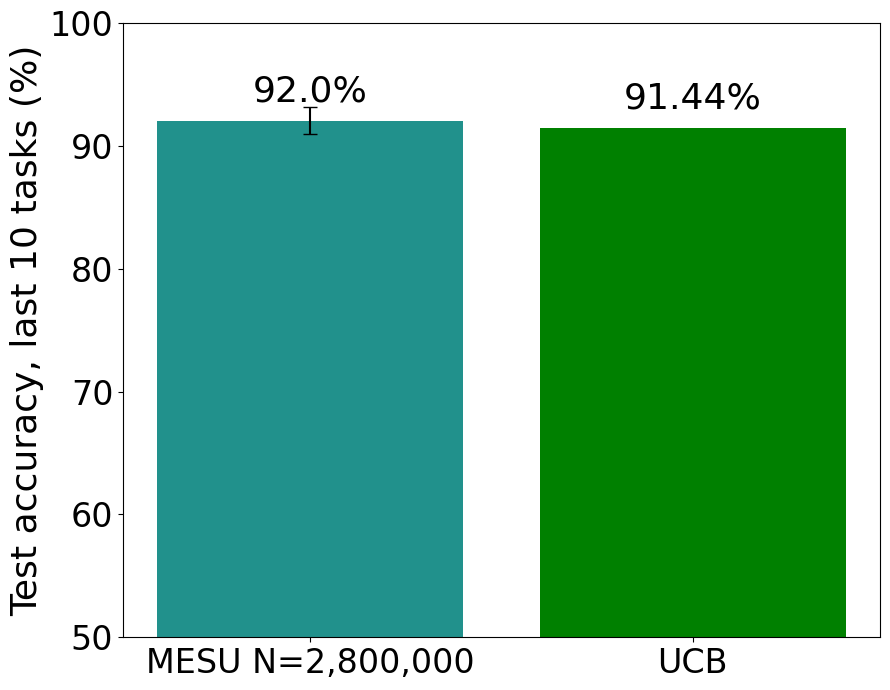

In [12]:
hidden_units = 128
current_df = df[df["layers"] == hidden_units]
fig, ax = plt.subplots(figsize=(9, 7))
colors = sns.color_palette("viridis", len(df[df["layers"] == hidden_units]))
N_name = re.sub(r'(\d)(?=(\d{3})+(?!\d))', r'\1,', str(current_df["N"].values[0]))
name = current_df["opt"].str.upper() + " N=" + N_name
plt.bar(
    name,
    current_df["last_accuracies"]*100,
    yerr=current_df["last_accuracies_std"]*100,
    color=colors,
    capsize=5,
)
# Text on each bar to indicate percentage
for i, (n, acc, std) in enumerate(zip(current_df["N"], current_df["last_accuracies"], current_df["last_accuracies_std"])):
    ax.text(i, acc*100 + 1, f"{acc*100:.1f}%", ha='center', va='bottom', fontsize=FONTSIZE)
    
# add bar 91.44
ax.bar(
    "UCB",
    91.44,
    color="green",
)
ax.text(len(current_df["N"]), 91.44 + 1, "91.44%", ha='center', va='bottom', fontsize=FONTSIZE)
ax.set_ylabel("Test accuracy, last 10 tasks (%)", fontsize=FONTSIZE)
ax.set_ylim(50, 100)

ax.tick_params(axis='both', which='major', labelsize=TICKSIZE)
ax.legend(fontsize=LEGENDSIZE, frameon=False)
plt.tight_layout()
plt.savefig(os.path.join(FOLDER, f"accuracy-layers-{hidden_units}.svg"))
plt.savefig(os.path.join(FOLDER, f"accuracy-layers-{hidden_units}.pdf"))